<a href="https://colab.research.google.com/github/brockmanmatt/gdelt_news_exploration/blob/master/NeuralNetworks_add_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OVERVIEW

Uses the last 3 months of GDELT V2 data to build neural network for forecasting news coverage!

In [1]:
# Here hook into the Google Drive, etc.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#cd /content/gdrive/"My Drive"/[DIRECTORY GOES HERE]

# DATA ACQUISITION

* Part 1: News Coverage
  * GDELT

* Part 2: Form time series
 * Hmm, I think having similar time series may improve but then adding random ones not seeing as much improvement; also only using a few months of data (because I really just care about integrating with the 3 month Google search) so that could limit

* Part 3: Train network

In [0]:
#get GDELT amd related files

In [0]:
#set this to True if you want to download the data
download_data = False

In [0]:
if download_data:
  !pip install gdelt
  import gdelt
  gd = gdelt.gdelt(version=2)

In [0]:
#This will download all days of GDELT v2 to a folder called data
#This will take ~2gb per day, or 200gb total

if download_data:
  import datetime
  cur_date = datetime.datetime(2019,8,1)
  end_date = datetime.datetime.today()-datetime.timedelta(days=2)

  import os
  os.makedirs("data", exist_ok=True)

  results = ""

  while cur_date < end_date:

    print("%s-%s-%s"%(cur_date.year, cur_date.month, cur_date.day))
    if not os.path.exists("data/%s-%s-%s.pkl"%(cur_date.year, cur_date.month, cur_date.day)):
      year = cur_date.year
      month = str(cur_date.month)
      day = str(cur_date.day)
      
      if cur_date.month < 10:
        month = "0"+month
      if cur_date.day < 10:
        day = "0"+day

      try:
        results = gd.Search(['%s %s %s'%(year, month, day)],table='gkg',coverage=True, translation=False)
        results.to_pickle("data/%s-%s-%s.pkl"%(cur_date.year, cur_date.month, cur_date.day))
      except:
        print("{} had an error".format(cur_date))

    cur_date+=datetime.timedelta(days=1)

In [0]:
#get Google search files

# Let's try with V2!

1.   List item
2.   List item



In [0]:
import os
import pandas as pd

In [0]:
if download_data:
  os.makedirs("smaller_data2", exist_ok=True)

  bad = ["wsj.com",
         "dailykos.com",
         "motherjones.com",
  ]

  potential_targets = ["washingtonpost.com", 
             "wsj.com", 
             "nytimes.com", 
             "foxnews.com", 
             "cnn.com", 
             "msnbc.com", 
             "reuters.com", 
             "breitbart.com", 
             "dailykos.com",
             "dailycaller.com",
             "dailywire.com",
             "dailysignal.com",
             "politico.com",
             "thehill.com",
             "motherjones.com",
             "nypost.com",
             ]

  targets = []
  for target in potential_targets:
    if target in bad:
      continue
    targets.append(target)


  potential_files = os.listdir("data")
  idx=0

  for daily_articles in potential_files:

    print (daily_articles)

    print ("{}/{}".format(idx,len(potential_files)))

    idx+=1

    if daily_articles in os.listdir("smaller_data2"):
      continue

    if not daily_articles.endswith(".pkl"):
      continue

    test_df = pd.read_pickle("data/"+daily_articles)


    test_df = test_df[test_df.SourceCommonName.isin(targets)]


    test_df.to_pickle("smaller_data2/" + daily_articles)

In [0]:
if download_data:
  df = pd.DataFrame()

  idx = 0
  for day in os.listdir("smaller_data2"):
    print(day)
    df = pd.concat([df, pd.read_pickle("smaller_data2/" + day)])

In [0]:
if download_data:
  df.DATE = df.DATE.apply(lambda x: str(int(x)))
  df.DATE = pd.to_datetime(df.DATE)

  import datetime
  df = df[df.DATE < datetime.datetime(2019,11,11)]
  df.fillna("", inplace=True)

  df.set_index("DATE", inplace=True, drop=True)
  df.to_pickle("3_months_df_extended_pubs.pkl")

In [0]:
if download_data:
  df = pd.read_pickle("3_months_df_extended_pubs.pkl")

In [0]:
if not download_data:
  df = pd.read_pickle("3_months_df_extended_pubs.pkl")

# back to um, 1D

In [18]:
df[df.V2Themes.apply(lambda x: x.lower().find("impeach") > -1)]["V2Themes"].head()

DATE
2019-08-01 00:00:00    ELECTION,194;TAX_FNCACT_EDITOR,24;TAX_POLITICA...
2019-08-01 00:15:00    USPEC_POLITICS_GENERAL1,66;EPU_POLICY_CONGRESS...
2019-08-01 00:30:00    TAX_FNCACT_CANDIDATES,960;EPU_POLICY_CONGRESSI...
2019-08-01 00:45:00    TAX_POLITICAL_PARTY_REPUBLICANS,3310;TAX_POLIT...
2019-08-01 02:15:00    KILL,443;WB_696_PUBLIC_SECTOR_MANAGEMENT,256;W...
Name: V2Themes, dtype: object

In [0]:
time_series = pd.DataFrame()

for pub in df.SourceCommonName.unique():
  time_series = pd.concat([time_series, df[(df.SourceCommonName == pub) & (df.V2Locations.apply(lambda x: x.find("Ukraine") > -1))].resample("D").count()[["SourceCollectionIdentifier"]].rename(columns={"SourceCollectionIdentifier":pub + "_Ukraine"})], axis=1)

In [0]:
for pub in df.SourceCommonName.unique():
  time_series = pd.concat([time_series, df[(df.SourceCommonName == pub) & (df.V2Locations.apply(lambda x: x.find("Russia") > -1))].resample("D").count()[["SourceCollectionIdentifier"]].rename(columns={"SourceCollectionIdentifier":pub + "_Russia"})], axis=1)

In [0]:
for pub in df.SourceCommonName.unique():
  time_series = pd.concat([time_series, df[(df.SourceCommonName == pub) & (df.V2Locations.apply(lambda x: x.find("China") > -1))].resample("D").count()[["SourceCollectionIdentifier"]].rename(columns={"SourceCollectionIdentifier":pub + "_China"})], axis=1)

In [0]:
for pub in df.SourceCommonName.unique():
  time_series = pd.concat([time_series, df[(df.SourceCommonName == pub) & (df.V2Themes.apply(lambda x: x.lower().find("impeach") > -1))].resample("D").count()[["SourceCollectionIdentifier"]].rename(columns={"SourceCollectionIdentifier":pub + "_Impeachment"})], axis=1)

In [0]:
for pub in df.SourceCommonName.unique():
  time_series = pd.concat([time_series, df[(df.SourceCommonName == pub) & (df.V2Themes.apply(lambda x: x.upper().find("TAX_POLITICAL_PARTY_REPUBLICANS") > -1))].resample("D").count()[["SourceCollectionIdentifier"]].rename(columns={"SourceCollectionIdentifier":pub + "_Republicans"})], axis=1)

In [0]:
for pub in df.SourceCommonName.unique():
  time_series = pd.concat([time_series, df[(df.SourceCommonName == pub) & (df.V2Themes.apply(lambda x: x.upper().find("TAX_POLITICAL_PARTY_DEMOCRATS") > -1))].resample("D").count()[["SourceCollectionIdentifier"]].rename(columns={"SourceCollectionIdentifier":pub + "_Democrats"})], axis=1)

In [0]:
for pub in df.SourceCommonName.unique():
  time_series = pd.concat([time_series, df[(df.SourceCommonName == pub) & (df.V2Themes.apply(lambda x: x.upper().find("IMMIGRATION") > -1))].resample("D").count()[["SourceCollectionIdentifier"]].rename(columns={"SourceCollectionIdentifier":pub + "_Immigration"})], axis=1)

In [0]:
for pub in df.SourceCommonName.unique():
  time_series = pd.concat([time_series, df[(df.SourceCommonName == pub) & (df.V2Themes.apply(lambda x: x.upper().find("DISCRIMINATION_RACE") > -1))].resample("D").count()[["SourceCollectionIdentifier"]].rename(columns={"SourceCollectionIdentifier":pub + "_RacialDiscrimination"})], axis=1)

In [0]:
for pub in df.SourceCommonName.unique():
  time_series = pd.concat([time_series, df[(df.SourceCommonName == pub) & (df.V2Themes.apply(lambda x: x.upper().find("EDUCATION") > -1))].resample("D").count()[["SourceCollectionIdentifier"]].rename(columns={"SourceCollectionIdentifier":pub + "_Education"})], axis=1)

In [0]:
time_series.fillna(0, inplace=True)
#time_series = time_series[time_series.index > datetime.datetime(2019,9,1)]

In [170]:
time_series.head()

reuters.com_Ukraine  ...  dailycaller.com_Education
DATE                             ...                           
2019-08-01                   19  ...                        7.0
2019-08-02                   18  ...                        4.0
2019-08-03                    0  ...                        2.0
2019-08-04                    1  ...                        4.0
2019-08-05                    5  ...                        1.0

[5 rows x 117 columns]

In [0]:
# goog = pd.read_pickle("GoogleData/impeachment_ukraine.pkl")

In [0]:
# time_series = pd.concat([time_series,goog[["impeachment", "ukraine"]].add_prefix("search_")], axis=1).dropna()

In [173]:
time_series.head()

reuters.com_Ukraine  ...  dailycaller.com_Education
DATE                             ...                           
2019-08-01                   19  ...                        7.0
2019-08-02                   18  ...                        4.0
2019-08-03                    0  ...                        2.0
2019-08-04                    1  ...                        4.0
2019-08-05                    5  ...                        1.0

[5 rows x 117 columns]

In [0]:
test_cov = pd.DataFrame()

test_cov = pd.concat([time_series.shift(x).add_suffix("_{}".format(x)) for x in range(1,7)], axis=1)

for issue in time_series.columns:
  for ma in range(1,7):
    test_cov["{}_sma{}".format(issue, ma)] = time_series[[issue]].rolling(window=ma).mean().shift()

for day in range(7):
  test_cov["d{}".format(day)] = test_cov.index.map(lambda x: 1 if x.weekday()==day else 0)

test_cov = test_cov[7:]

In [175]:
len(test_cov.columns)

1411

In [0]:
testing = time_series.join(test_cov).dropna()

In [0]:
testing["date"] = testing.index

So here's what I want:
instead of a bunch of time series together, take each column and stick as new;
so basically, 

In [0]:
preprocessed_data = testing.melt(id_vars = list(test_cov.columns) + ["date"],
    var_name="Topic", 
        value_name="Articles")

In [0]:
#preprocessed_data["publisher"] = preprocessed_data["Topic"].apply(lambda x: x.split("_")[0])

In [0]:
#convert to unix time

In [0]:
import time
preprocessed_data["date"] = preprocessed_data["date"].apply(lambda t: time.mktime(t.timetuple()))

In [0]:
from fastai.tabular import *

In [0]:
os.makedirs("tabular", exist_ok=True)

In [0]:
preprocessed_data.sort_values(by="date", ascending=True,inplace=True)

In [0]:
pub_dict = {}
topic_dict = {}
for x in time_series.columns:
  y = x.split("_")
  try:
    pub_dict[y[0]] += 1
  except:
    pub_dict[y[0]] =1

  try:
    topic_dict[y[1]] += 1
  except:
    topic_dict[y[1]] =1


In [186]:
len(topic_dict)

9

In [0]:
validation_days = 14
test_days = 7

In [0]:
validation_length = len(pub_dict) * len(topic_dict)*validation_days
test_length = len(pub_dict) * len(topic_dict) * test_days

In [0]:
preprocessed_data["publication"] = preprocessed_data["Topic"].apply(lambda x: x.split("_")[0])
preprocessed_data["theme"] = preprocessed_data["Topic"].apply(lambda x: x.split("_")[1])

In [0]:
preprocessed_data = preprocessed_data[[x for x in preprocessed_data.columns if x!="Articles"]+["Articles"]]

In [0]:
# Tabular templated from https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson4-tabular.ipynb

In [0]:
preprocessed_data.reset_index(inplace=True,drop=True)

In [193]:
preprocessed_data.head()

reuters.com_Ukraine_1  cnn.com_Ukraine_1  ...        theme  Articles
0                    6.0                1.0  ...      Ukraine      15.0
1                    6.0                1.0  ...        China       0.0
2                    6.0                1.0  ...  Immigration      29.0
3                    6.0                1.0  ...    Education     164.0
4                    6.0                1.0  ...       Russia     138.0

[5 rows x 1416 columns]

In [0]:
# dep_var = 'Articles'
# cat_names = ['Topic'] + [x for x in preprocessed_data.columns if (len(x) < 4)]
# cont_names = [x for x in preprocessed_data.columns if x not in ["Articles"]+cat_names]
# procs = [Categorify, Normalize]

# os.makedirs("tabular", exist_ok=True)
# path = "tabular"

# test = TabularList.from_df(preprocessed_data[-test_length:].copy(), path=path, cat_names=cat_names, cont_names=cont_names)

# shuffled = preprocessed_data[:-test_length].sample(frac=1).reset_index(drop=True).copy()

In [0]:
# data = (TabularList.from_df(shuffled, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
#                            .split_by_idx(list(range(len(shuffled)-validation_length, len(shuffled))))
#                            .label_from_df()
#                            .add_test(test)
#                            .databunch())

In [0]:
dep_var = 'Articles'
cat_names = ['Topic'] + [x for x in preprocessed_data.columns if (len(x) < 12)]
cont_names = [x for x in preprocessed_data.columns if x not in ["Articles"] + cat_names]
procs = [Categorify, Normalize]

os.makedirs("tabular", exist_ok=True)
path = "tabular"

test = TabularList.from_df(preprocessed_data[-test_length:].copy(), path=path, cat_names=cat_names, cont_names=cont_names)


In [0]:
validation_start = len(preprocessed_data) - test_length - validation_length

In [0]:
data = (TabularList.from_df(preprocessed_data[:-test_length], path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(range(validation_start, validation_start + validation_length))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [0]:
learn = tabular_learner(data, layers=[len(time_series.columns)*6,len(time_series.columns)*4, len(time_series.columns)*3, len(time_series.columns)*2, len(time_series.columns)], emb_drop=.0, ps=[ .05, .05, .15, .1, 0], metrics=accuracy)

In [232]:
learn.fit(6)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


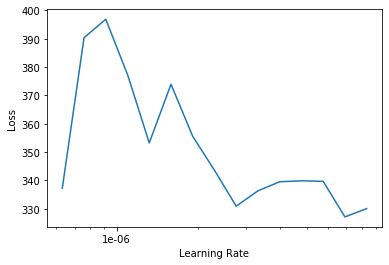

In [233]:
learn.lr_find()
learn.recorder.plot()

In [234]:
learn.fit_one_cycle(1, max_lr=(4e-6))

In [0]:
#oops, it bounced out. a lot. whatever. this is just to demo. That's not supposed to be 20

In [0]:
learn.freeze_to(3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


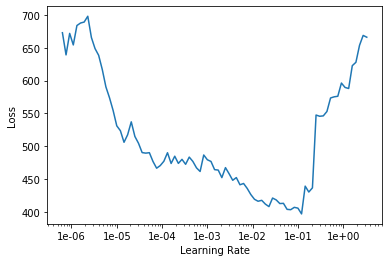

In [239]:
learn.lr_find()
learn.recorder.plot()

In [240]:
learn.fit_one_cycle(1, max_lr=(2e-2))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


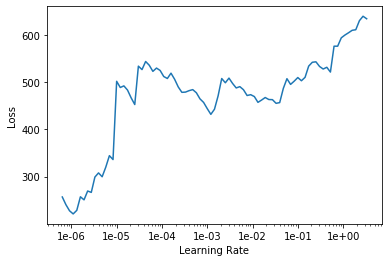

In [256]:
learn.lr_find()
learn.recorder.plot()

In [257]:
learn.fit_one_cycle(3, max_lr=(1e-6))

In [0]:
learn.freeze_to(4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


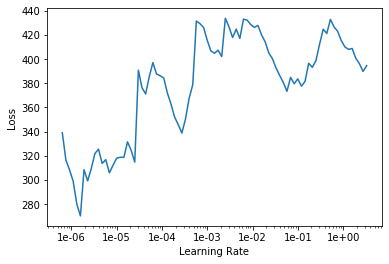

In [259]:
learn.lr_find()
learn.recorder.plot()

In [260]:
learn.fit_one_cycle(3, max_lr=(3e-6))

In [0]:
learn.freeze_to(5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


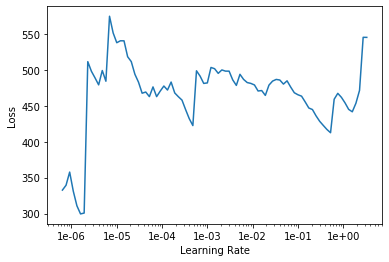

In [263]:
learn.lr_find()
learn.recorder.plot()

In [265]:
learn.fit_one_cycle(2, 2e-6)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


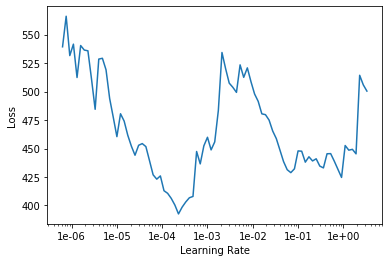

In [268]:
learn.lr_find()
learn.recorder.plot()

In [272]:
learn.fit_one_cycle(1, 2e-4)

In [0]:
learn.unfreeze()

In [274]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(118, 23)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
    (7): Embedding(3, 3)
    (8): Embedding(75, 18)
    (9): Embedding(118, 23)
    (10): Embedding(14, 7)
    (11): Embedding(10, 6)
    (12): Embedding(250, 35)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(1404, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=1537, out_features=702, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=702, out_features=468, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(468, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
    (8): Line

In [0]:
predictions_Train, *_ = learn.get_preds(ds_type=DatasetType.Fix)
predictions_Valid, *_ = learn.get_preds(DatasetType.Valid)
predictions_Test, *_ = learn.get_preds(DatasetType.Test)

In [276]:
print(len(predictions_Train), len(predictions_Valid), len(predictions_Test))

8658 1638 819


In [0]:
#len(predictions_Train) + len(predictions_Valid)

In [0]:
all_preds = ([x[0].item() for x in predictions_Train] + [x[0].item() for x in predictions_Valid] + [x[0].item() for x in predictions_Test])

In [0]:
a = preprocessed_data[:-test_length][["date","Topic", "Articles"]].copy()

In [0]:
b = preprocessed_data[["date","Topic", "Articles"]][-test_length:].copy()

In [0]:
r = pd.concat([a,b])

In [0]:
r["p"] = all_preds

In [0]:
r.date = pd.to_datetime(r['date'],unit='s')

In [0]:
r.set_index("date", inplace=True, drop=True)

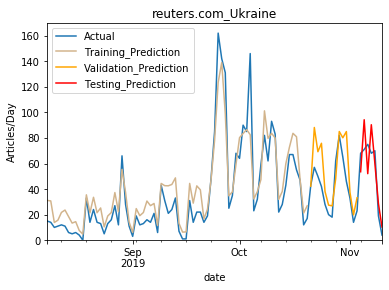

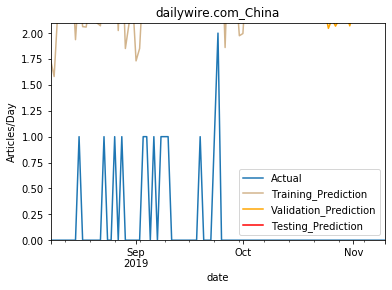

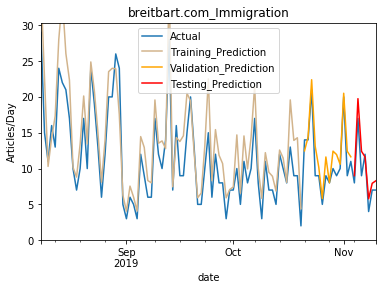

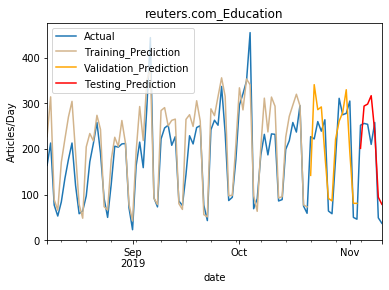

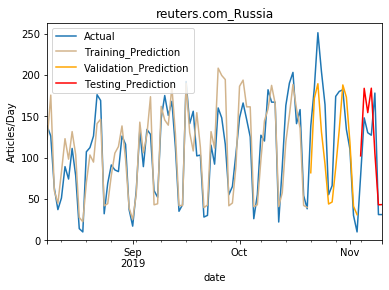

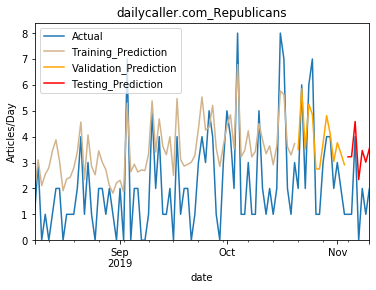

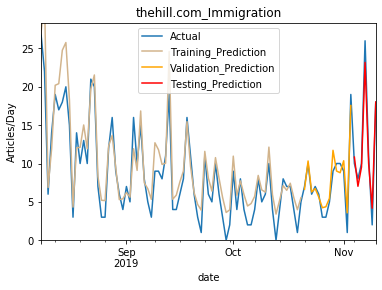

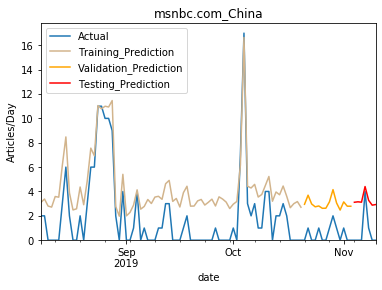

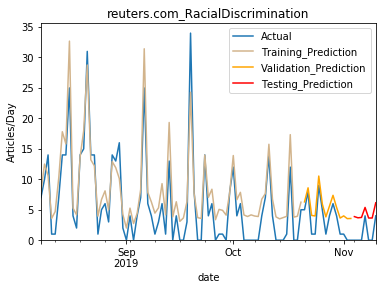

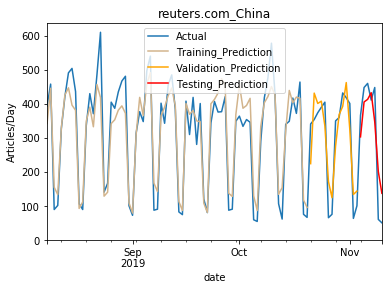

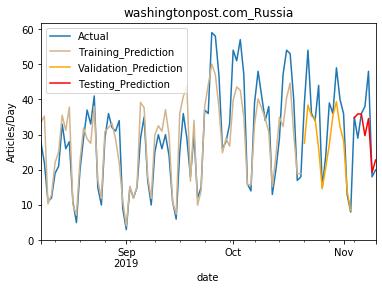

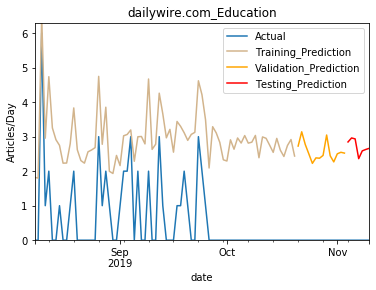

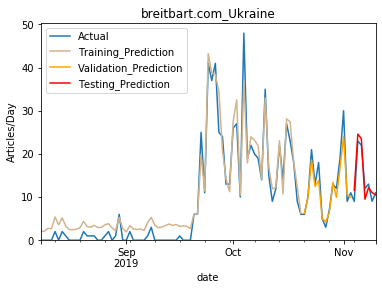

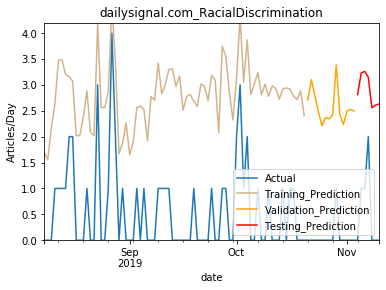

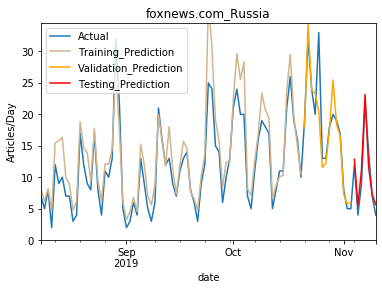

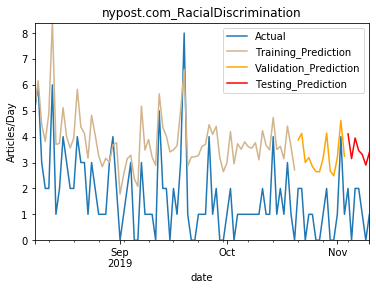

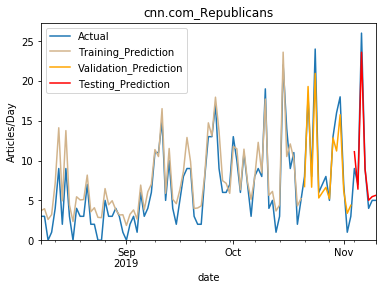

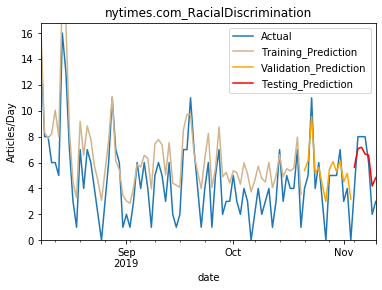

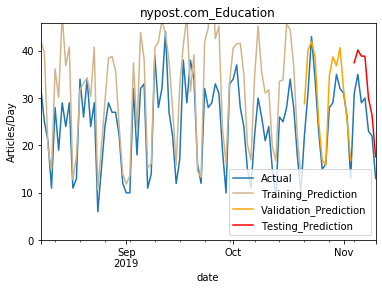

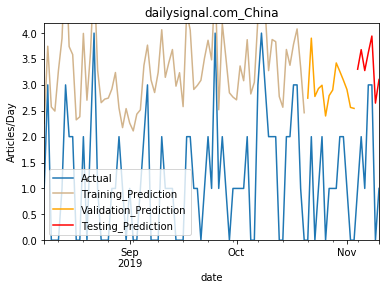

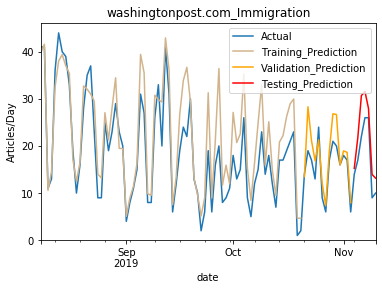

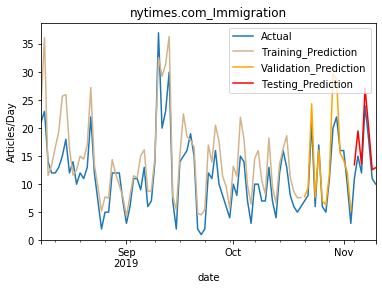

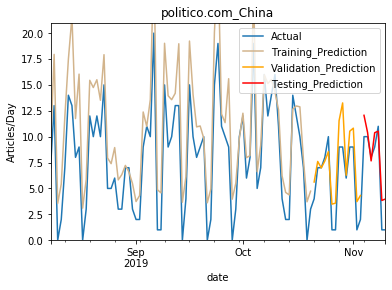

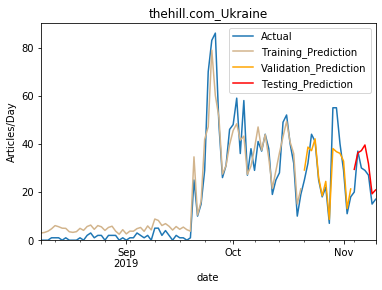

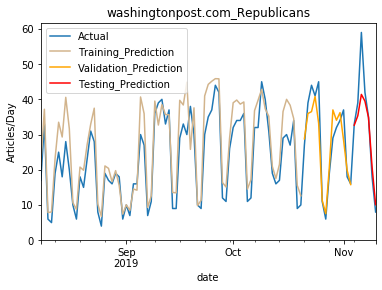

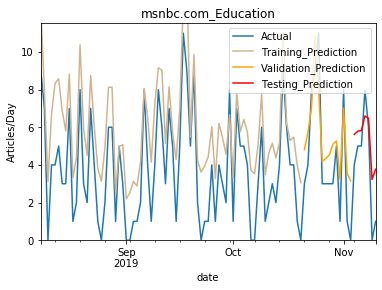

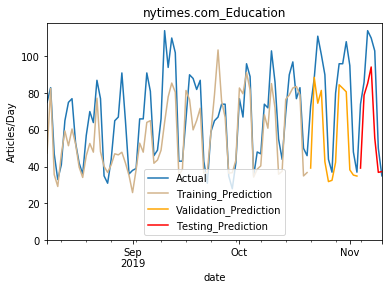

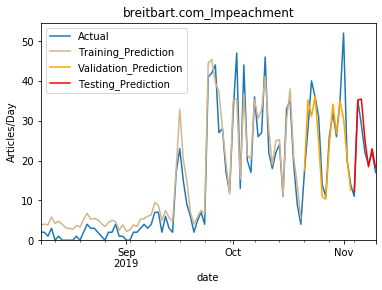

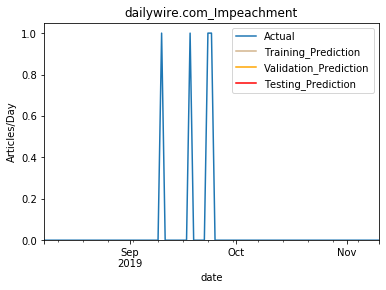

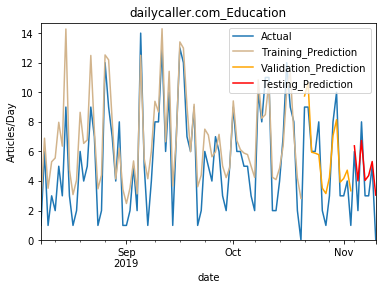

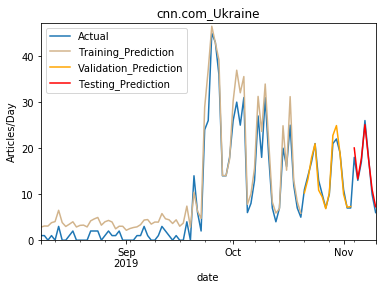

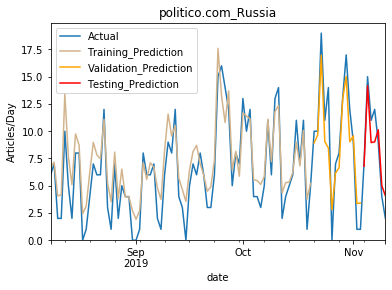

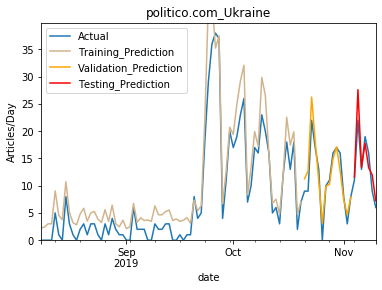

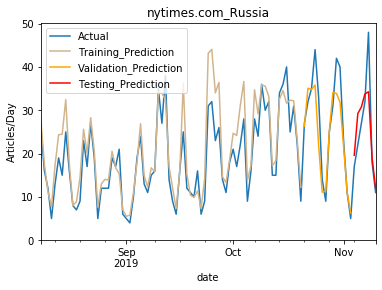

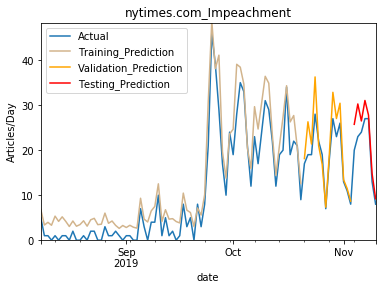

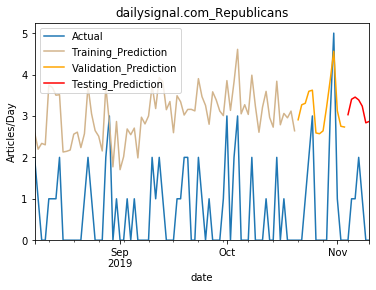

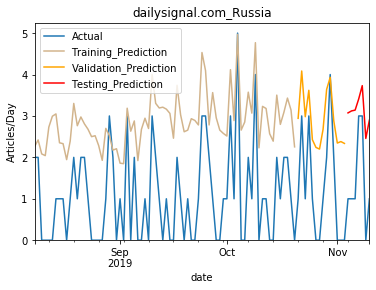

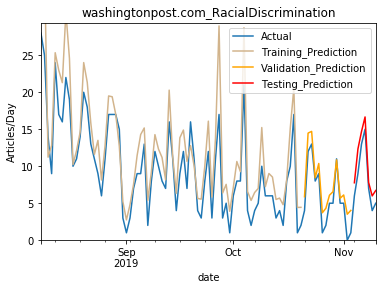

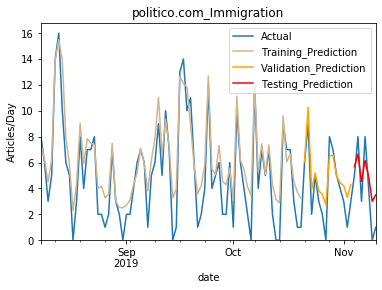

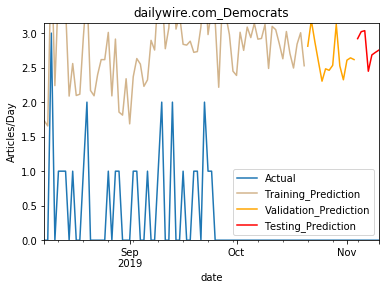

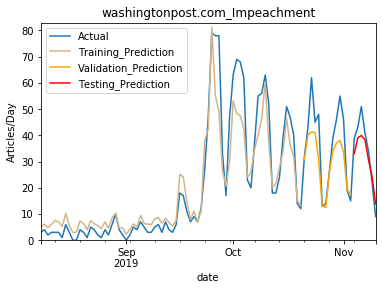

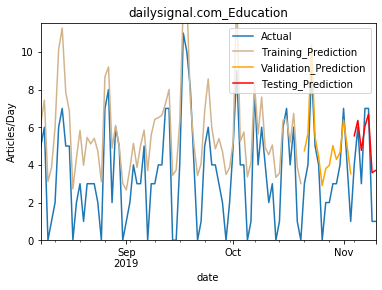

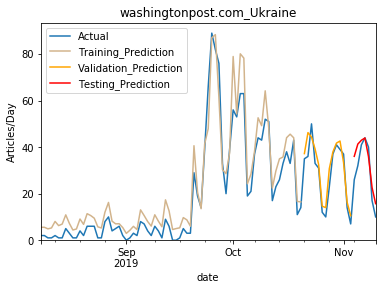

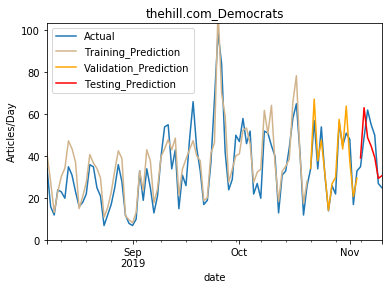

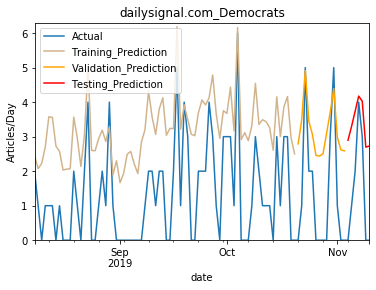

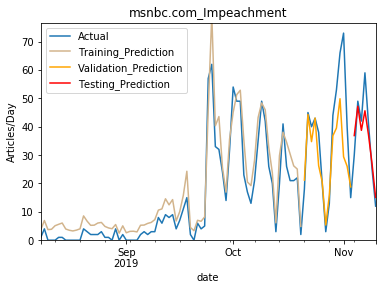

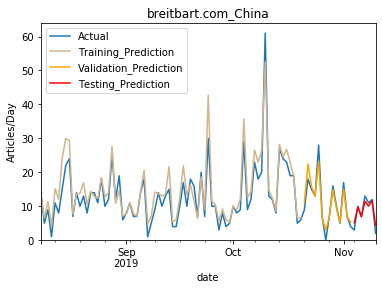

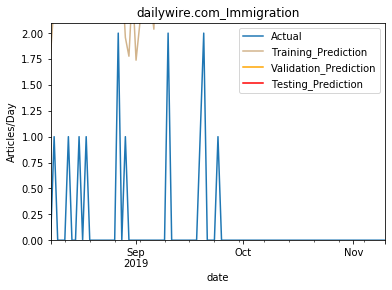

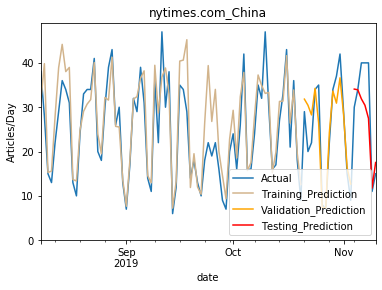

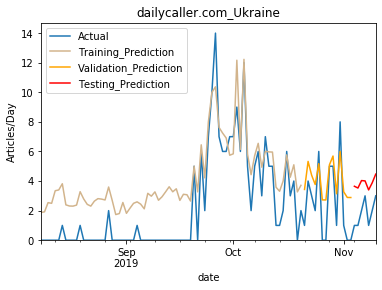

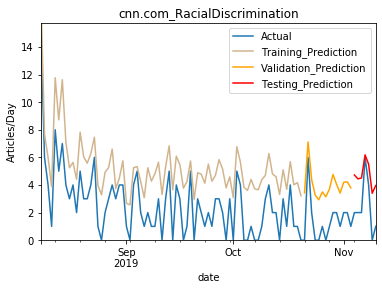

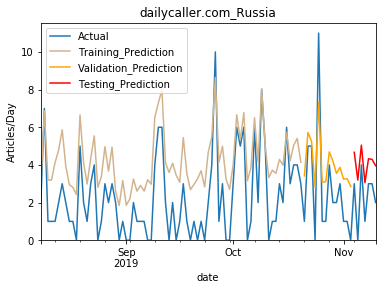

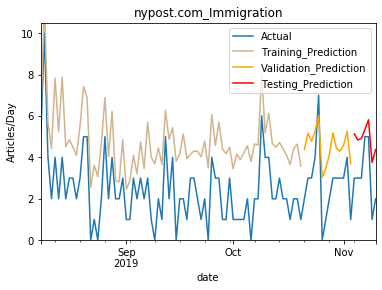

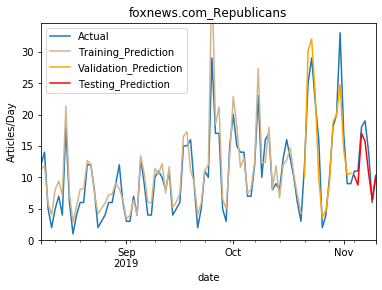

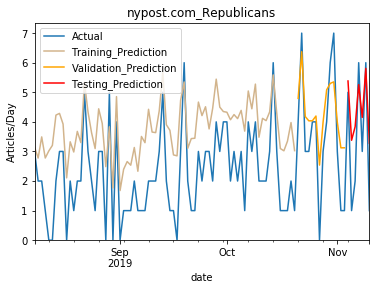

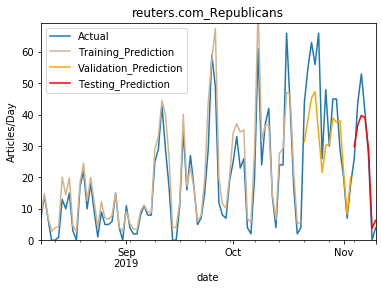

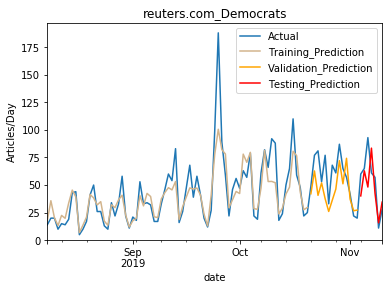

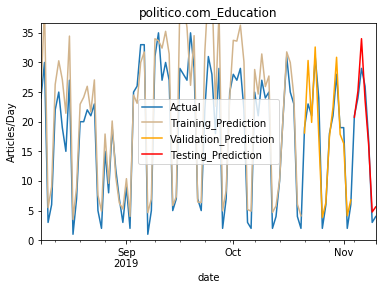

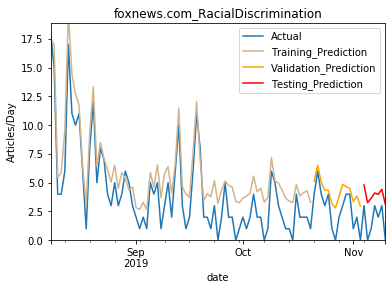

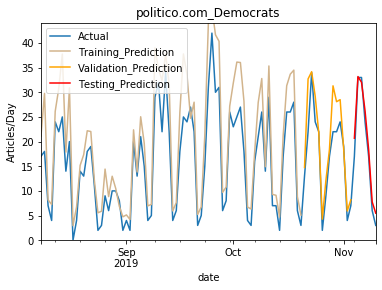

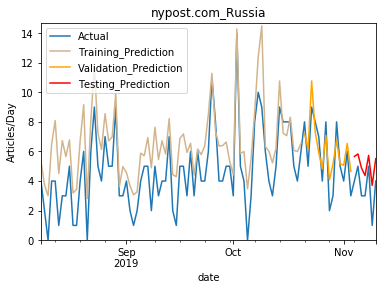

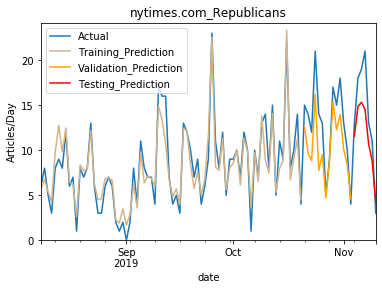

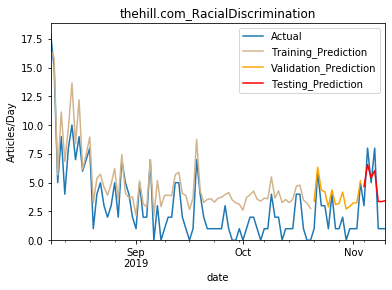

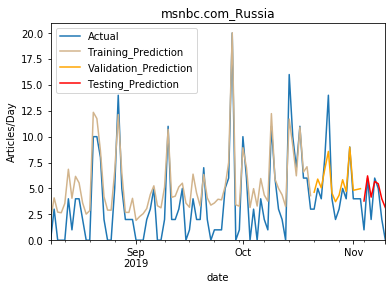

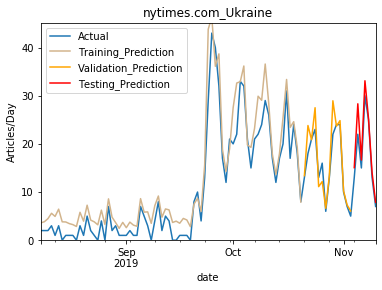

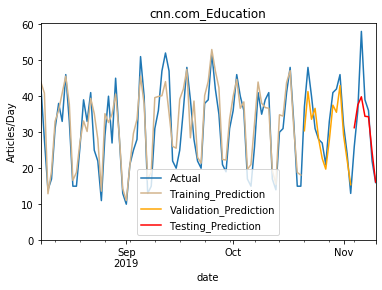

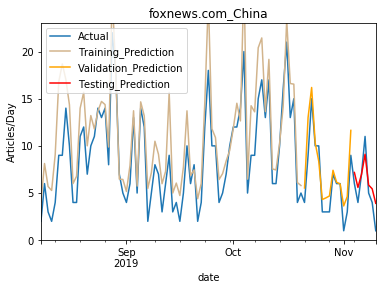

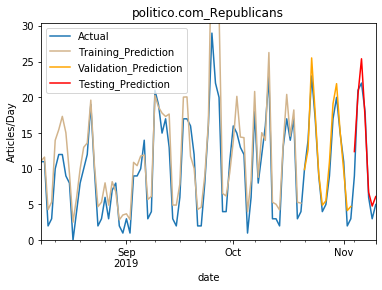

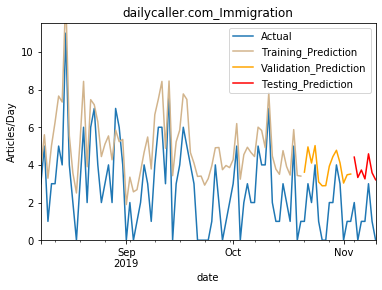

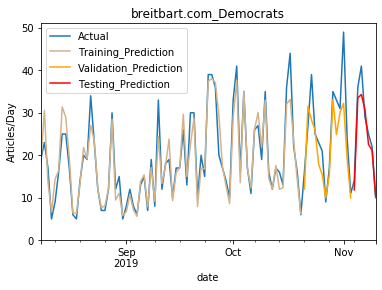

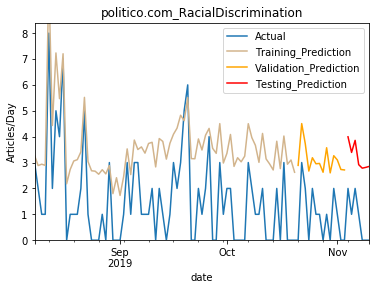

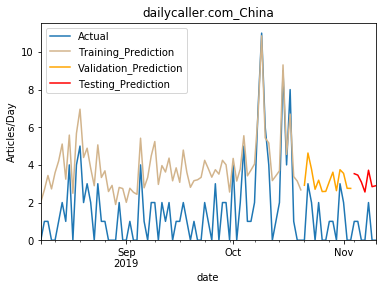

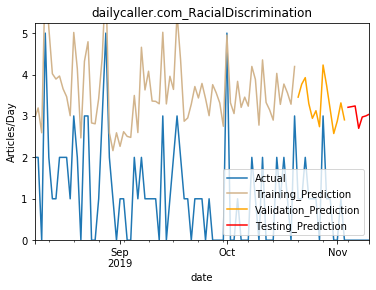

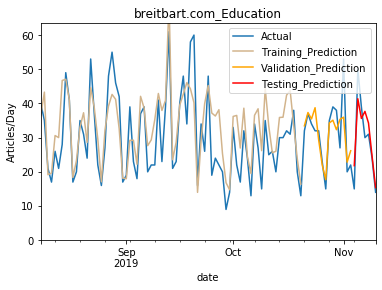

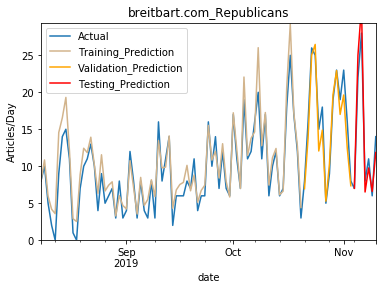

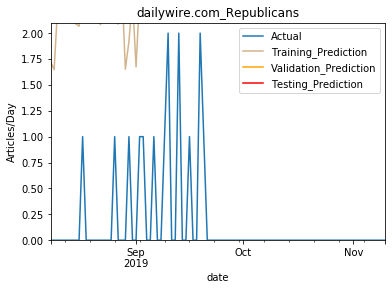

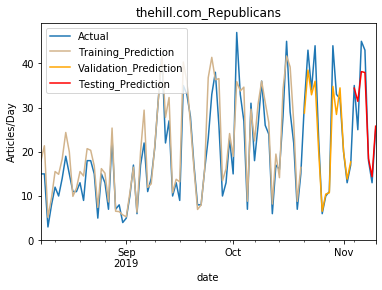

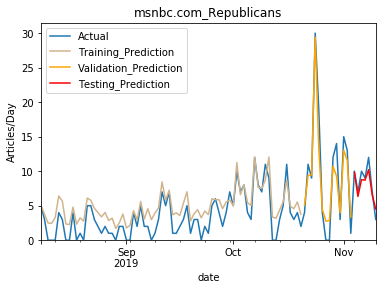

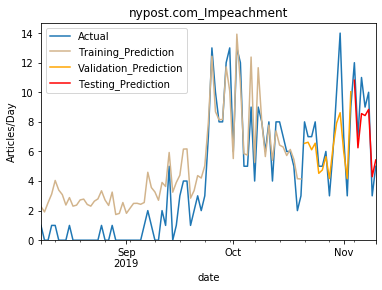

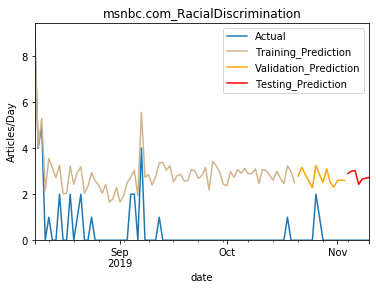

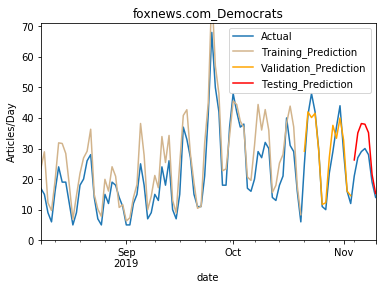

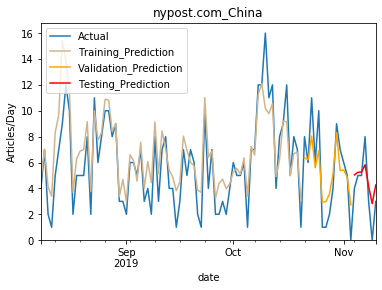

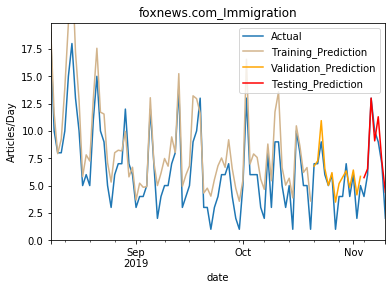

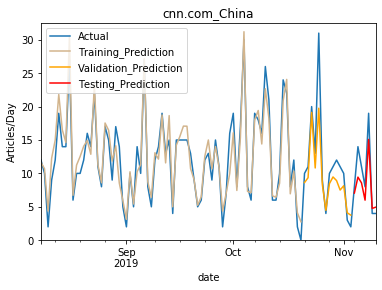

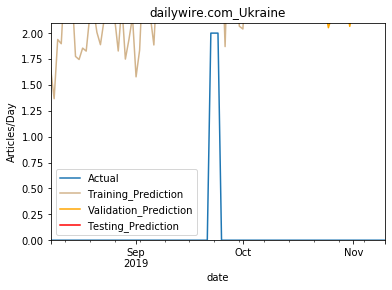

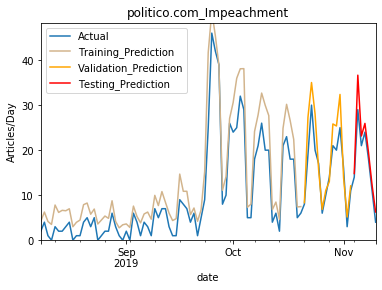

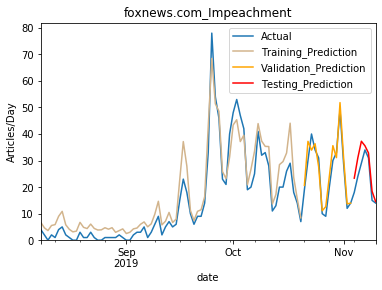

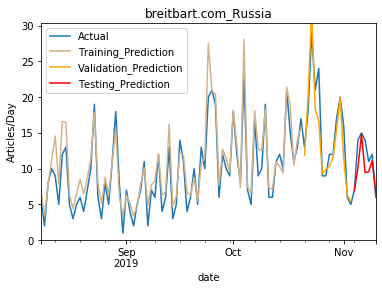

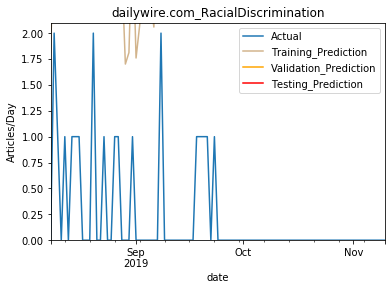

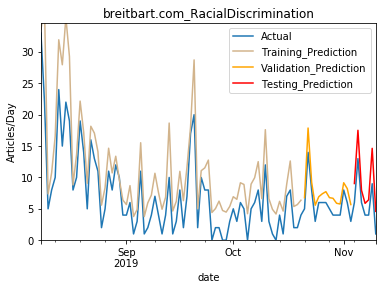

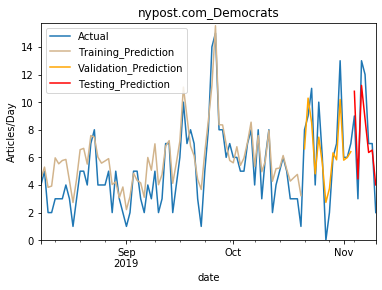

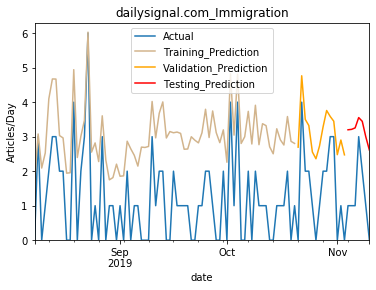

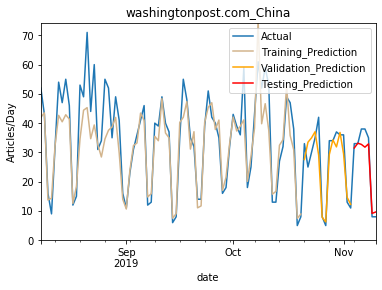

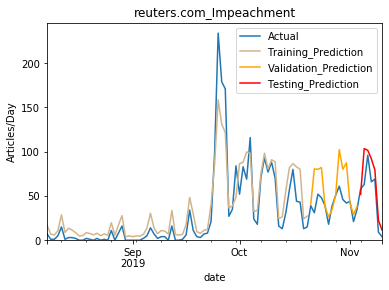

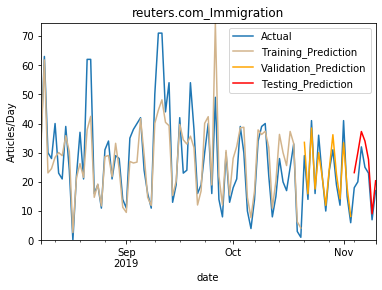

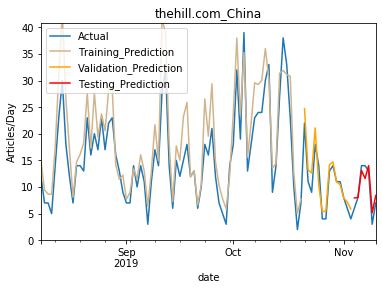

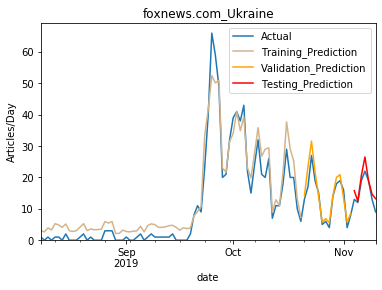

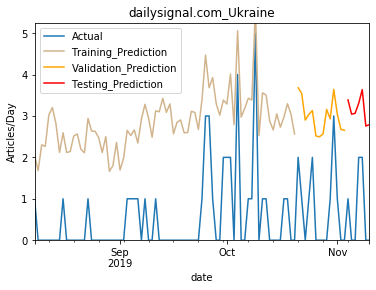

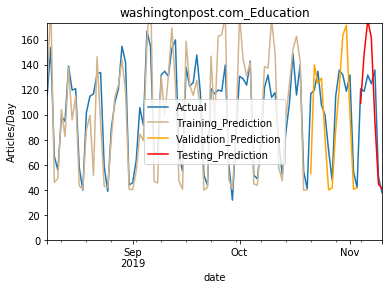

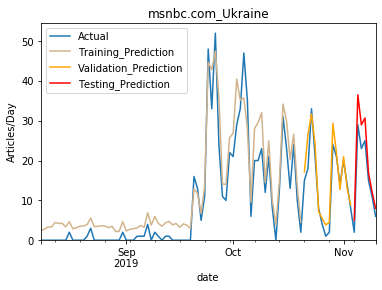

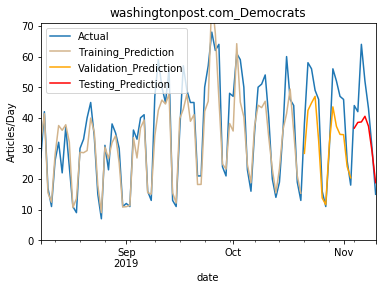

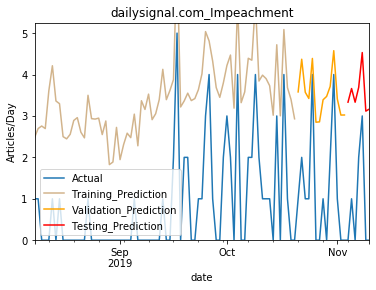

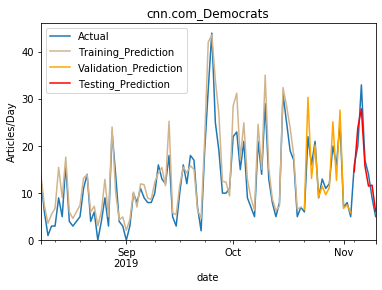

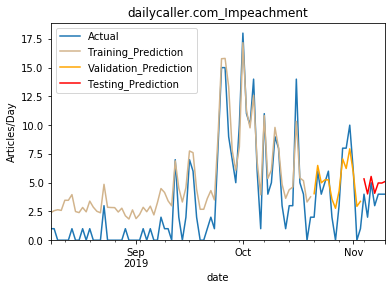

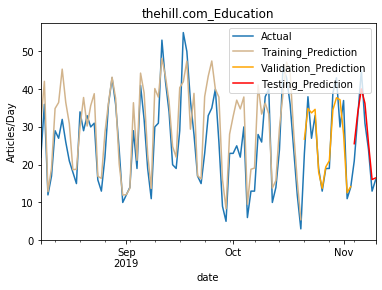

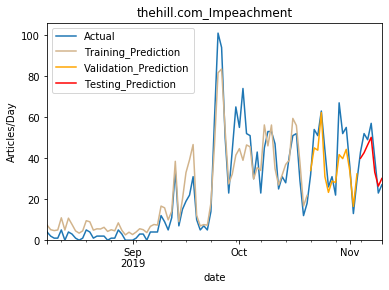

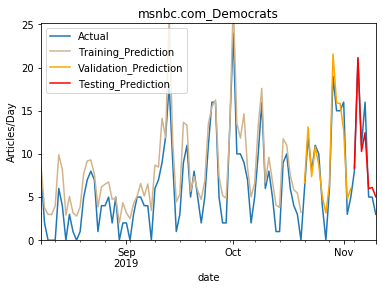

In [285]:
os.makedirs("imgs", exist_ok=True)
idx = 0
for topic in r.Topic.unique():
  ax = r[r.Topic==topic]["Articles"].plot(title="Topic: {}".format(topic), ylim=0, label="Actual")

  r[r.Topic==topic]["p"][:-(validation_days + test_days)].plot(title="{}".format(topic), ax=ax, ylim=0, color="tan", label="Training_Prediction")
  r[r.Topic==topic]["p"][-(validation_days + test_days):-test_days].plot(title="{}".format(topic), ax=ax, ylim=0, color="orange", label="Validation_Prediction")
  r[r.Topic==topic]["p"][-test_days:].plot(title="{}".format(topic), ax=ax, ylim=0, color="red", label="Testing_Prediction")
  
  idx +=1

  ax.set_ylabel("Articles/Day")

  ax.legend()
  #save images; you probably don't want to
  if True:
    plt.savefig('imgs/{}.png'.format(topic.replace(".", "_")), bbox_inches='tight')
  plt.show()


In [163]:
fig, axs = plt.subplots(4, int(len(r.Topic.unique())/4)+1, figsize=(60,15), sharex=True, facecolor="white")
x = y = 0

for topic in r.Topic.unique():
  r[r.Topic==topic]["Articles"].plot(title="{}".format(topic), ax=axs[x,y], ylim=0, label="Actual")

  r[r.Topic==topic]["p"][:-(validation_days + test_days)].plot(title="{}".format(topic), ax=axs[x,y], ylim=0, color="tan", label="Training_Prediction")
  r[r.Topic==topic]["p"][-(validation_days + test_days):-test_days].plot(title="{}".format(topic), ax=axs[x,y], ylim=0, color="orange", label="Validation_Prediction")
  r[r.Topic==topic]["p"][-test_days:].plot(title="{}".format(topic), ax=axs[x,y], ylim=0, color="red", label="Testing_Prediction")

  axs[x,y].legend()

  if x == 0 and y==0:
    handles, labels = axs[0,0].get_legend_handles_labels()

  axs[x,y].get_legend().remove()

  if y==0:
    axs[x,y].set_ylabel("Articles/Day")

  x+=1
  if x > 3:
    x =0
    y+=1


fig.legend(handles, labels, loc='center right',bbox_to_anchor=(1.03,.75))
fig.tight_layout()

fig.suptitle("Neural Network Predictions by Day", y=1.02)

Text(0.5, 1.02, 'Neural Network Predictions by Day')

Error in callback <function flush_figures at 0x7f2ad8a071e0> (for post_execute):


KeyboardInterrupt: ignored

# I don't really plan on updating this much; just doing it for a demonstration. Although it's cool that it works.